In [46]:
import numpy as np
import pandas as pd
import torch
import os

from sklearn.decomposition import PCA

In [47]:
ROI = "early_visual"
folder_path = f"/gpfs/milgram/scratch60/turk-browne/neuromanifold/StudyForrest/MNI152_3mm_data/denoised_filtered_smoothed/ROI_data/{ROI}/data"
file_suffix = "movie_all_runs.npy"
patient_ids = [1, 2, 3, 4, 5, 6, 9, 10, 14, 15]

In [48]:
class DataLoader:
    def __init__(self, ROI, folder_path, file_suffix, patient_ids):
        self.ROI = ROI
        self.folder_path = folder_path
        self.file_suffix = file_suffix
        self.patient_ids = patient_ids
        
        self.patients_data = []
        for p in patient_ids:
            movie_data = np.load(os.path.join(folder_path, f'sub-{p:02}_{ROI}_{file_suffix}'))
            self.patients_data.append(movie_data)
            
        self.time_range = self.patients_data[0].shape[0]
        
    def get_timelength(self):
        return self.time_range
    
    def return_stacked(self, data, stacked):
        if stacked:
            return np.vstack(data)
        else:
            return data
    
    def get_first_half(self, stacked=True):
        first_half = [x[:self.time_range//2] for x in self.patients_data]
        return self.return_stacked(first_half, stacked)
    
    def get_second_half(self, stacked=True):
        second_half = [x[self.time_range//2:] for x in self.patients_data]
        return self.return_stacked(second_half, stacked)
    
    def leave_out(self, test_subject, half=None, stacked=True):
        if half == None:
            data = [x for x, i in zip(self.patients_data, self.patient_ids) if i != test_subject]
            return self.return_stacked(data, stacked)
        else:
            if half == 1:
                data = [x for x, i in zip(self.get_first_half(False), self.patient_ids) if i != test_subject]
                return self.return_stacked(data, stacked)
            else:
                data = [x for x, i in zip(self.get_second_half(False), self.patient_ids) if i != test_subject]
                return self.return_stacked(data, stacked)

In [49]:
dataloader = DataLoader(ROI, folder_path, file_suffix, patient_ids)

### Version 1

- run PCA on all subjects
- get loadings of PCA on N-1 subjects
- apply to leave-out subject

In [50]:
# run PCA on all subjects
pca = PCA(n_components=64)
X = dataloader.return_stacked(dataloader.patients_data, True)
print(X.shape)
x_new = pca.fit_transform(X)
print(x_new.shape)

(35990, 166)
(35990, 64)


In [56]:
# get loadings of PCA on N-1 subjects

pca = PCA(n_components=64)
X = dataloader.leave_out(test_subject=1)
print(X.shape)
T = pca.fit_transform(X)


loadings = pca.components_

(32391, 166)


In [111]:
embeds = x_new.reshape(len(patient_ids), dataloader.get_timelength(), -1)
idx = patient_ids.index(1)

(embeds[idx] @ loadings) + pca.mean_

(x_new @ loadings) + pca.mean_

array([[-0.17571844, -2.47872783, -2.68577066, ..., -0.27987438,
        -1.66442112, -0.77811383],
       [-0.78308972, -0.18843308, -0.86325808, ..., -2.57465691,
        -1.00139999, -2.51613717],
       [-2.13650082, -0.37470421, -1.07476007, ..., -1.43808745,
        -0.64725372, -1.80498029],
       ...,
       [ 2.48836603,  0.12086809,  0.92858358, ...,  0.50812231,
         0.02518643, -0.02546497],
       [ 1.47342941, -0.96820496, -0.42548519, ..., -1.16953452,
        -1.45603911, -0.89355583],
       [ 0.25796917,  0.05083116, -0.76672286, ..., -2.36018616,
        -1.67674892, -2.05610408]])

### Version 2

- get PCA loadings of all subjects for one half of the movie
- get PCA loadings of N-1 subjects for the same half of the movie

- test on second half:
    - embed test data of N-th partipcant with first loadings 
    - inverse process using the second set of loadings

In [135]:
X_1 = dataloader.get_first_half()
pca = PCA(n_components=64)
pca.fit(X_1)
encoding_loadings = pca.components_
encoding_mean = pca.mean_

In [136]:
X_2 = dataloader.leave_out(test_subject=1)
pca = PCA(n_components=64)
pca.fit(X_2)
decoding_loadings = pca.components_
decoding_mean = pca.mean_

In [137]:
X_test = dataloader.get_second_half()
n_pt = len(patient_ids)
X_test = X_test.reshape(n_pt, X_test.shape[0] // n_pt, -1)

In [141]:
embed = (X_test[0] @ encoding_loadings.T)

In [143]:
x_hat = (embed @ decoding_loadings)
x_hat

array([[-0.06670553, -0.62885322, -1.28881099, ...,  0.97488382,
         1.26125974,  1.93094785],
       [-1.69040673, -1.56562007, -1.09454218, ...,  0.89925351,
         0.91954992,  1.14295264],
       [ 0.3253594 , -1.0393062 , -1.66567624, ..., -0.37795828,
         0.84866676,  0.25333152],
       ...,
       [-1.0070456 , -0.71043168, -1.38841839, ..., -1.27174081,
        -0.6365991 , -1.32073569],
       [-0.8955774 ,  1.50428701,  0.32330669, ..., -0.54876086,
         0.80559221, -0.64807658],
       [-0.01864544,  1.84042374,  1.21071926, ...,  0.52154512,
         0.44352455,  0.92446314]])

In [67]:
dataloader = DataLoader(ROI, folder_path, file_suffix, patient_ids)

In [68]:
test = np.vstack(dataloader.patients_data)
np.mean(test[3])

4.280377926265664e-17

In [69]:
test_0 = np.array(dataloader.patients_data)
test_0 = np.swapaxes(test_0, 0, 1)
test_0.shape

(3599, 10, 166)

In [70]:
means = np.mean(test_0, axis=0)
stds = np.std(test_0, axis=0)

In [71]:
test_0[:, 2, :].shape

(3599, 166)

In [72]:
for i in range(len(patient_ids)):
    test_0[:, i, :] = (test_0[:, i, :] - means[i]) / stds[i]

In [73]:
test_0 = np.swapaxes(test_0, 1, 0).reshape(len(patient_ids) * 3599, -1)

Calculating PHATE...
  Running PHATE on 35990 observations and 166 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 11.87 seconds.
    Calculating KNN search...
    Calculated KNN search in 216.05 seconds.
    Calculating affinities...
    Calculated affinities in 7.58 seconds.
  Calculated graph and diffusion operator in 235.55 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.94 seconds.
    Calculating KMeans...
    Calculated KMeans in 34.04 seconds.
  Calculated landmark operator in 39.36 seconds.
  Calculating optimal t...
    Automatically selected t = 16
  Calculated optimal t in 2.92 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 17.82 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.49 seconds.
Calculated PHATE in 301.16 seconds.


<AxesSubplot:>

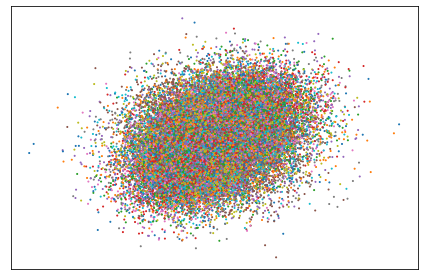

In [74]:
import phate

phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(test_0)

import scprep

n_embeds_per_pt = test_0.shape[0] // len(patient_ids)

pid_labels = []

# for i in range(1, 15):
for i in patient_ids:
    pid_labels.extend([i] * n_embeds_per_pt)
pid_labels = np.array(pid_labels)

assert(len(pid_labels) == test_0.shape[0])

scprep.plot.scatter2d(test_0, c=pid_labels, discrete=True, ticks=False, legend=False)

In [10]:
mean = np.mean(test, axis=0)

In [11]:
std = np.std(test, axis=0)

In [12]:
import copy
new_test = copy.deepcopy(test)
for i in range(test.shape[0]):
    new_test[i] = (new_test[i] - mean) / std

In [13]:
import phate

phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(new_test)

Calculating PHATE...
  Running PHATE on 35990 observations and 166 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.76 seconds.
    Calculating KNN search...
    Calculated KNN search in 239.35 seconds.
    Calculating affinities...
    Calculated affinities in 7.21 seconds.
  Calculated graph and diffusion operator in 254.38 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.76 seconds.
    Calculating KMeans...
    Calculated KMeans in 42.16 seconds.
  Calculated landmark operator in 47.31 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 2.98 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 29.01 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.48 seconds.
Calculated PHATE in 339.19 seconds.


<AxesSubplot:>

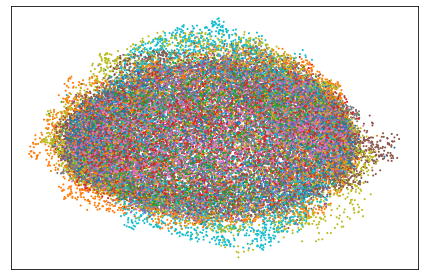

In [14]:
import scprep

n_embeds_per_pt = data_phate.shape[0] // len(patient_ids)

pid_labels = []

# for i in range(1, 15):
for i in patient_ids:
    pid_labels.extend([i] * n_embeds_per_pt)
pid_labels = np.array(pid_labels)

assert(len(pid_labels) == data_phate.shape[0])

scprep.plot.scatter2d(data_phate, c=pid_labels, discrete=True, ticks=False, legend=False)

In [15]:
import phate

phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(test)

Calculating PHATE...
  Running PHATE on 35990 observations and 166 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.63 seconds.
    Calculating KNN search...
    Calculated KNN search in 239.39 seconds.
    Calculating affinities...
    Calculated affinities in 6.41 seconds.
  Calculated graph and diffusion operator in 253.49 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.69 seconds.
    Calculating KMeans...
    Calculated KMeans in 37.76 seconds.
  Calculated landmark operator in 42.84 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 2.98 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 24.19 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.53 seconds.
Calculated PHATE in 329.04 seconds.


<AxesSubplot:>

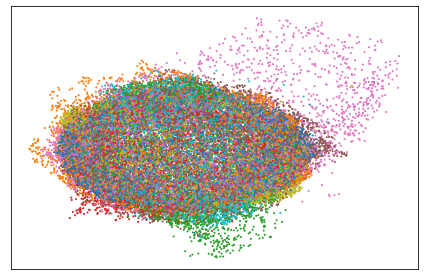

In [16]:
import scprep

n_embeds_per_pt = data_phate.shape[0] // len(patient_ids)

pid_labels = []

# for i in range(1, 15):
for i in patient_ids:
    pid_labels.extend([i] * n_embeds_per_pt)
pid_labels = np.array(pid_labels)

assert(len(pid_labels) == data_phate.shape[0])

scprep.plot.scatter2d(data_phate, c=pid_labels, discrete=True, ticks=False, legend=False)

In [7]:
from lib.fMRI import fMRI_Time_Subjs_Dataset, fMRI_Time_Subjs_Embed_Dataset, fMRIAutoencoderDataset

In [9]:
dataset = fMRI_Time_Subjs_Embed_Dataset(patient_ids,
                                folder_path,
                                f"/gpfs/milgram/scratch60/turk-browne/neuromanifold/StudyForrest/MNI152_3mm_data/denoised_filtered_smoothed/ROI_data/{ROI}/embeddings",
                                np.arange(1799),
                                emb_name_suffix=f"{ROI}_movie_split1_20dimension_embedding_PHATE.npy",
                                data_3d=False,
                                data_name_suffix="early_visual_movie_all_runs.npy")

input data shape: (10, 1799, 166)
embedding data shape: (10, 1799, 20)


In [10]:
dataset.timeseries.shape

(1799, 10, 166)

In [42]:
mean = np.mean(dataset.timeseries, axis=0)
std = np.std(dataset.timeseries, axis=0)

In [43]:
mean.shape

(166,)

In [37]:
for i in range(dataset.timeseries.shape[]):
    dataset.timeseries[i] = (dataset.timeseries[i] - mean) / std 

In [39]:
dataset.timeseries.shape[1]

166

In [27]:
dataset = fMRIAutoencoderDataset(patient_ids,
                                folder_path,    
                                np.arange(1799),
                                data_3d=False,
                                data_name_suffix="early_visual_movie_all_runs.npy")

loading data from patient 1 into memory
loading data from patient 2 into memory
loading data from patient 3 into memory
loading data from patient 4 into memory
loading data from patient 5 into memory
loading data from patient 6 into memory
loading data from patient 9 into memory
loading data from patient 10 into memory
loading data from patient 14 into memory
loading data from patient 15 into memory


In [40]:
((dataset.timeseries - np.mean(dataset.timeseries, axis=0)) / np.std(dataset.timeseries, axis=0)).shape

(17990, 166)

In [26]:
(np.array([[5,4,3,2,1], [5,4,3,2,1]]) - np.array([1,2,3,4,5])) / np.array([1,2,3,4,5])

array([[ 4. ,  1. ,  0. , -0.5, -0.8],
       [ 4. ,  1. ,  0. , -0.5, -0.8]])